### Importing required libraries

In [ ]:
#import libraries required

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #for plotting of graphs
import seaborn as sns# for plotting of graphs
%matplotlib inline


np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vaishnavi514","key":"6637d7f0bc1f378661e5067c388736e0"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         98           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        208           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        477           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       3250           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      26214           False  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       6609           False  
connectx

In [ ]:
!kaggle competitions download -c digit-recognizer # downloading kaggle digit recognizer

 55% 5.00M/9.16M [00:00<00:00, 38.6MB/s]
100% 9.16M/9.16M [00:00<00:00, 58.5MB/s]
  0% 0.00/6.09M [00:00<?, ?B/s]
100% 6.09M/6.09M [00:00<00:00, 56.0MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 75.0MB/s]


In [ ]:
# unzip the dataset
!unzip -q "../content/train.csv.zip"
!unzip -q "../content/test.csv.zip"

In [ ]:
#deleting the zip files
!rm -rf test.csv.zip
!rm -rf train.csv.zip

In [ ]:
# dataset read
train = pd.read_csv("../content/train.csv")
test = pd.read_csv("../content/test.csv")
train.head() #printing first five rows

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

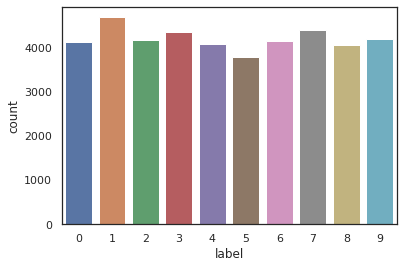

In [ ]:
train.shape
y_train = train["label"] #copy the label column of train dataset to y_train dataset
#drop label column
x_train = train.drop(labels=["label"],axis=1)
#plotting count plot for the digits labelled 
g =sns.countplot(y_train)
y_train.value_counts()

In [ ]:
train.shape
# shape of the the dataset

(42000, 785)

In [ ]:
y_train[0]
# number present at the first label

1

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(test.shape)
#print shape of all datasets

(42000, 784)
(42000,)
(28000, 784)


### Checking for Missing Values


In [ ]:
# Check the data
x_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [ ]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

I check for corrupted images (missing values inside).

There is no missing values in the train and test dataset. 

### Reshape

In [ ]:
# For each pixel you would need 3 scalars (each for one channel), so it would be 60000x28x28x3.
# And how many channels you need when the image is in greyscale? Just one, so it would be 60000x28x28x1
# x_train = x_train.values.reshape(42000,28,28,1)
import numpy as np
x_train = x_train.values.reshape(-1,28,28,1)
print(x_train.shape)
test = test.values.reshape(-1,28,28,1)
print(test.shape)

(42000, 28, 28, 1)
(28000, 28, 28, 1)


### Normalisation
Normalising data by dividing it by 255 should improve activation functions performance - sigmoid function works more efficiently with data range 0.0-1.0

In [ ]:
x_train = x_train/255.0
test = test/255.0

### Label encoding

In [ ]:
#one-hot encoding
# encode the data to convert labels into 10 numbers for input to neural networks
y_train = to_categorical(y_train,num_classes =10)
y_train.shape

(42000, 10)

In [ ]:
print(train['label'].head())
print(y_train[0:5,:])

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### Split training and valdiation set 

In [ ]:
# Split the train and the validation set for the fitting
X_train,X_val,Y_train,Y_val = train_test_split(x_train,y_train,test_size = 0.1 , random_state = 2)

In [ ]:
print("X Train shape",X_train.shape)
print("Y Train shape",Y_train.shape)
print("X Test shape ",X_val.shape)
print("Y test shape ",Y_val.shape)

X Train shape (37800, 28, 28, 1)
Y Train shape (37800, 10)
X Test shape  (4200, 28, 28, 1)
Y test shape  (4200, 10)


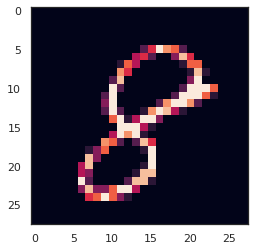

In [ ]:
g = plt.imshow(X_train[0][:,:,0])